In [126]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [127]:
dg = xr.open_dataset('outer_avg.nc')
dg

<xarray.Dataset>
Dimensions:         (tracer: 2, boundary: 4, s_rho: 30, s_w: 31, eta_rho: 317,
                     xi_rho: 272, eta_u: 317, xi_u: 271, eta_v: 316, xi_v: 272,
                     eta_psi: 316, xi_psi: 271, ocean_time: 30)
Coordinates:
  * s_rho           (s_rho) float64 -0.9715 -0.9156 ... -0.0156 -0.004799
  * s_w             (s_w) float64 -1.0 -0.9433 -0.8883 ... -0.02161 -0.01 0.0
    lon_rho         (eta_rho, xi_rho) float64 ...
    lat_rho         (eta_rho, xi_rho) float64 ...
    lon_u           (eta_u, xi_u) float64 ...
    lat_u           (eta_u, xi_u) float64 ...
    lon_v           (eta_v, xi_v) float64 ...
    lat_v           (eta_v, xi_v) float64 ...
    lon_psi         (eta_psi, xi_psi) float64 ...
    lat_psi         (eta_psi, xi_psi) float64 ...
  * ocean_time      (ocean_time) datetime64[ns] 1994-02-01 ... 1994-03-02
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, eta_u, xi_u,
                                eta_v, xi_v, eta_psi, xi_psi
Data variables: (12/128)
    ntimes          int32 ...
    ndtfast         int32 ...
    dt              float64 ...
    dtfast          float64 ...
    dstart          datetime64[ns] ...
    nHIS            int32 ...
    ...              ...
    rain            (ocean_time, eta_rho, xi_rho) float32 ...
    swrad           (ocean_time, eta_rho, xi_rho) float32 ...
    sustr           (ocean_time, eta_u, xi_u) float32 ...
    svstr           (ocean_time, eta_v, xi_v) float32 ...
    bustr           (ocean_time, eta_u, xi_u) float32 ...
    bvstr           (ocean_time, eta_v, xi_v) float32 ...
Attributes: (12/34)
    file:              outer_avg.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS nonlinear model averages file
    title:             EAC OUTER GRID
    var_info:          varinfo.dat
    ...                ...
    compiler_command:  /apps/openmpi/4.0.2/bin/mpif90
    compiler_flags:    -fp-model precise -heap-arrays -ip -O3 -traceback -che...
    tiling:            006x008
    history:           ROMS/TOMS, Version 3.9, Thursday - November 23, 2023 -...
    ana_file:          ROMS/Functionals/ana_btflux.h
    CPP_options:       EAC, ADD_FSOBC, ADD_M2OBC, ANA_BSFLUX, ANA_BTFLUX, ASS...

In [128]:
xi_slice = slice(80, 110)
eta_slice = slice(10, 150)

lat_rho = dg["lat_rho"].isel(eta_rho=eta_slice, xi_rho=xi_slice)
lon_rho = dg["lon_rho"].isel(eta_rho=eta_slice, xi_rho=xi_slice)
lat_u = dg["lat_u"].isel(eta_u=eta_slice, xi_u=xi_slice)
lon_u = dg["lon_u"].isel(eta_u=eta_slice, xi_u=xi_slice)
lat_v = dg["lat_v"].isel(eta_v=eta_slice, xi_v=xi_slice)
lon_v = dg["lon_v"].isel(eta_v=eta_slice, xi_v=xi_slice)
pm = dg["pm"].isel(eta_rho=eta_slice, xi_rho=xi_slice)
pn = dg["pn"].isel(eta_rho=eta_slice, xi_rho=xi_slice)
h = dg["h"].isel(eta_rho=eta_slice, xi_rho=xi_slice)

area=np.divide(1,pm*pn)

In [129]:
land_mask = np.isnan(dg.temp.isel(ocean_time=0, s_rho=-1, eta_rho=eta_slice, xi_rho=xi_slice))

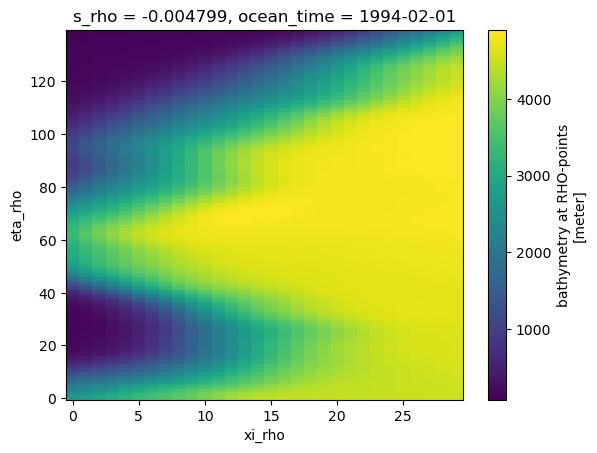

In [130]:
# dg.temp.isel(ocean_time=0, s_rho=-1).where(~land_mask).where(h <= 200).isel(eta_rho=slice(30, -50), xi_rho=slice(30, -170)).plot(y='lat_rho', x='lon_rho')
h = h.where(~land_mask)
h.plot()

In [131]:
# Fill in land with zeros:
h = h.fillna(0)
# h.where(h<=200).plot()


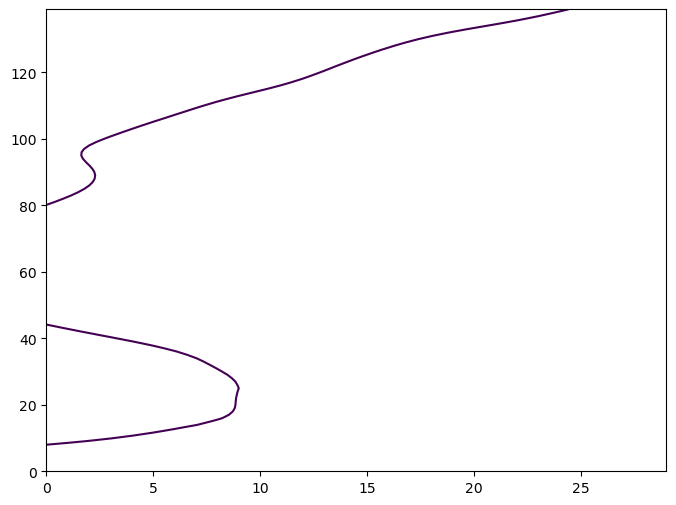

In [132]:
contour_depth = 1500.

grid_sel = 't'
x_var = lon_rho
y_var = lat_rho

fig = plt.figure(figsize = (8, 6))
count = 164 # contour 87 for 2000m isobath, 165 for 1500m
x_contour = []
y_contour = []

# Create the contour:
sc = plt.contour(h, levels=[contour_depth])
for collection in sc.collections:
    for path in collection.get_paths():
        # print(collection.get_paths())

        # count += 1
        # if count ==  212:
        # Write down the lat/lon indices
        for ii in range(np.size(path.vertices[:,0])):
            if int(np.round(path.vertices[ii][0])) < 125:   #FS added to select only the shelf break contour
                x_contour.append(int(np.round(path.vertices[ii][0])))
                y_contour.append(int(np.round(path.vertices[ii][1])))

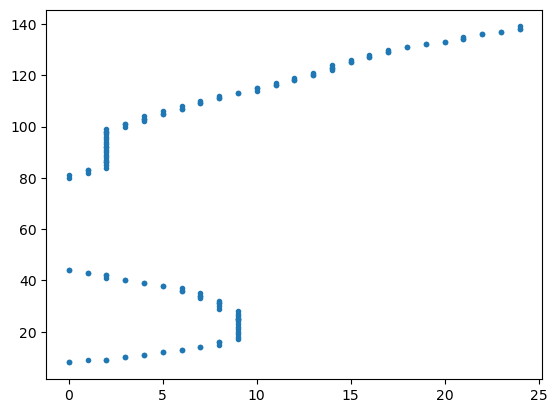

In [133]:
plt.plot(x_contour, y_contour, '.')

In [134]:
# Difference between two neighbouring indices
diff_x_contour = np.diff(x_contour)
diff_y_contour = np.diff(y_contour)


In [135]:
diff_x_contour

array([ 0,  1,  0,  1,  0,  0,  1,  0,  1,  0,  1,  0,  1,  0,  0,  1,  0,
        0,  0,  1,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0, -1,  0,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0,
       -1,  0, -1, -1,  0, 24,  0,  0, -1,  0, -1,  0, -1,  0,  0, -1,  0,
       -1,  0, -1,  0, -1,  0,  0, -1,  0,  0, -1,  0,  0, -1,  0,  0,  0,
       -1,  0,  0, -1,  0,  0, -1,  0,  0, -1,  0,  0, -1,  0, -1,  0,  0,
       -1,  0,  0, -1,  0,  0, -1,  0,  0, -1,  0,  0,  0, -1,  0,  0, -1,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0, -1,  0,  0, -1,  0])

In [136]:
# Get a list with the indices of duplicates
diff_ind = []
for ii in range(len(diff_x_contour)):
    if (diff_x_contour[ii]==0) and (diff_y_contour[ii]==0):
        diff_ind.append(ii)


In [137]:
# Now remove the indices (start from the end so the indices don't shift)
for ii in range(len(diff_ind)):
    index = diff_ind[::-1][ii]
    del x_contour[index]
    del y_contour[index]

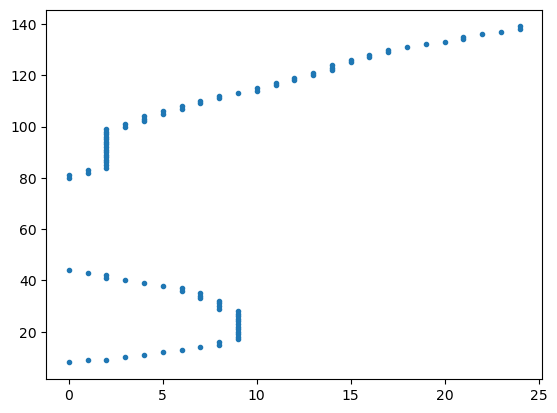

In [138]:
plt.plot(x_contour, y_contour, '.')

In [139]:
# Getting the bathymetry for the contour
h_contour = np.zeros(len(x_contour))

for ii in range(len(h_contour)):
    h_contour[ii] = h[y_contour[ii], x_contour[ii]]

Text(0.5, 1.0, 'This is the bathymetry for the chosen contour')

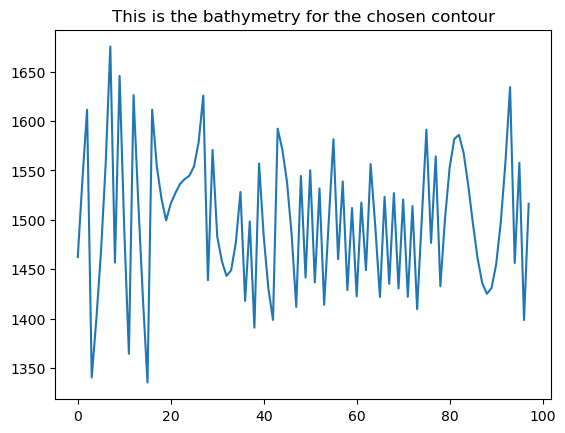

In [140]:
plt.plot(h_contour)
plt.title('This is the bathymetry for the chosen contour')

In [141]:
# Choose whether you want your contour on the u or t grid.
grid_sel = 't'

x_var = lon_rho
y_var = lat_rho


In [142]:
lat_along_contour = np.zeros((len(x_contour)))
lon_along_contour = np.zeros((len(x_contour)))

for ii in range(len(h_contour)):
    lon_along_contour[ii] = x_var[y_contour[ii-1],x_contour[ii-1]]
    lat_along_contour[ii] = y_var[y_contour[ii-1],x_contour[ii-1]]

In [143]:
lon_along_contour

array([151.04278674, 150.4046406 , 150.41326132, 150.42190642,
       150.40405434, 150.41273099, 150.42143227, 150.43015826,
       150.43890906, 150.42107792, 150.42986093, 150.41202943,
       150.39419024, 150.40301306, 150.38517357, 150.36732639,
       150.34947149, 150.35834197, 150.34048685, 150.32262399,
       150.30475339, 150.28687503, 150.2689889 , 150.25109497,
       150.23319323, 150.21528367, 150.19736627, 150.17944102,
       150.16150789, 150.11664871, 150.09868416, 150.05376504,
       150.00880942, 149.96381721, 149.9187883 , 149.8737226 ,
       149.82862001, 149.80161188, 149.75645936, 152.67439985,
       152.65749169, 152.61529561, 152.5730716 , 152.53081957,
       152.51385163, 152.47155339, 152.42922691, 152.38687214,
       152.34448899, 152.32744214, 152.28501212, 152.26794079,
       152.22546367, 152.2083677 , 152.16584324, 152.14872249,
       152.13159554, 152.08900475, 152.07185281, 152.02921409,
       152.01203701, 151.96935013, 151.95214774, 151.90

In [144]:
lat_along_contour = np.append(lat_along_contour, lat_along_contour[0])
lon_along_contour = np.append(lon_along_contour, lon_along_contour[0])

In [145]:
lat_along_contour

array([-35.34871484, -36.87327929, -36.92333519, -36.97339109,
       -37.01574011, -37.06579601, -37.11585191, -37.16590781,
       -37.21596371, -37.25831273, -37.30836863, -37.35071764,
       -37.39306665, -37.44312256, -37.48547157, -37.52782058,
       -37.57016959, -37.62022549, -37.66257451, -37.70492352,
       -37.74727253, -37.78962154, -37.83197056, -37.87431957,
       -37.91666858, -37.95901759, -38.00136661, -38.04371562,
       -38.08606463, -38.12070675, -38.16305577, -38.19769789,
       -38.23234001, -38.26698213, -38.30162425, -38.33626638,
       -38.3709085 , -38.36320161, -38.39784373, -33.03508848,
       -33.07743749, -33.11207961, -33.14672173, -33.18136386,
       -33.22371287, -33.25835499, -33.29299711, -33.32763924,
       -33.36228136, -33.40463037, -33.43927249, -33.48162151,
       -33.51626363, -33.55861264, -33.59325476, -33.63560377,
       -33.67795279, -33.71259491, -33.75494392, -33.78958604,
       -33.83193506, -33.86657718, -33.90892619, -33.94

In [146]:
# Number of grid points on the contour
num_points = len(lat_along_contour)

# Now we number the points along the contour
contour_mask_numbered = np.zeros_like(lon_along_contour)

for ii in range(num_points-1):
    lat1 = lat_along_contour[ii]
    lat2 = lat_along_contour[ii+1]
    lon1 = lon_along_contour[ii]
    lon2 = lon_along_contour[ii+1]
    contour_mask_numbered[ii] = ii

contour_mask = h*0

for ii in range(num_points-1):
    contour_mask[y_contour[ii], x_contour[ii]] = contour_mask_numbered[ii]+1

mask_value = -1000
contour_mask_numbered = contour_mask

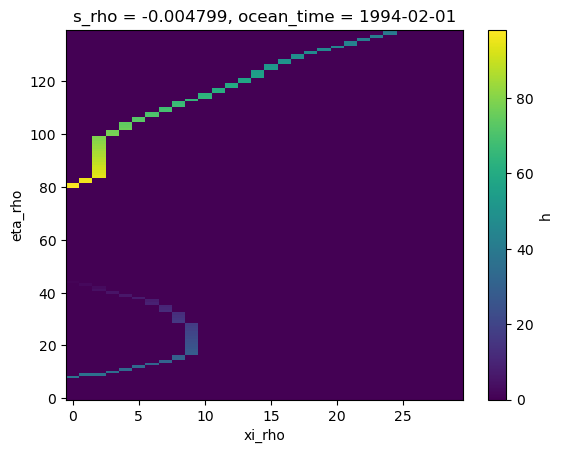

In [147]:
contour_mask_numbered.plot()

In [148]:
# fill in points to south of contour:
contour_masked_above = np.copy(contour_mask_numbered)
contour_masked_above[-1, 0] = mask_value

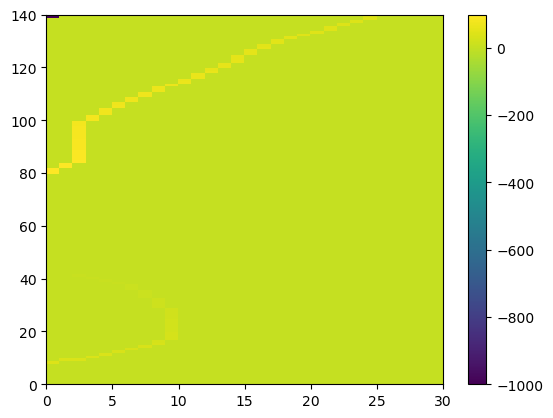

In [149]:
plt.pcolor(contour_masked_above)
plt.colorbar()

In [150]:
#Create mask
#Now we create a mask below contour sothat the direction of the contour can be determined

#Remark on computational inefficiency:
#Note that creating masks with nested for loops is very inefficient. We should probably use boolean masks (just compare the entire array with mask_value), and DataArray.shift() or DataArray.roll() from each of the directions to generate the masks without using loops.
#See discussion in: https://github.com/COSIMA/cosima-recipes/issues/179

print(contour_masked_above.shape, contour_mask_numbered.shape)
print(contour_masked_above[-20:-1, 0])

# fill in points to south of contour:
contour_masked_above = np.copy(contour_mask_numbered)
contour_masked_above[-1, 0] = mask_value

# from top left:
for ii in range(len(contour_mask[0,:])-1): #x: len(x-axis) - 1
    for jj in range(len(contour_mask[:,0]))[::-1][:-1]: #y: len(y-axis)[from end to start, inverse order][from first to (end-1)]
        if contour_masked_above[jj, ii] == mask_value: # if north of contour line
            if contour_masked_above[jj-1, ii] == 0: # if previous cell in Y-dir is zero (= south of contour line)
                contour_masked_above[jj-1, ii] = mask_value # make it -1000
            if contour_masked_above[jj, ii+1] == 0: # if next cell in X-dir is zero
                contour_masked_above[jj, ii+1] = mask_value # make it -1000

#from top right:
for ii in range(len(contour_mask[0,:]))[::-1][:-1]:
    for jj in range(len(contour_mask[:,0]))[::-1][:-1]:
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj-1, ii] == 0: # if previous cell in Y-dir is zero
                contour_masked_above[jj-1, ii] = mask_value
            if contour_masked_above[jj, ii-1] == 0: # if previous cell in X-dir is zero
                contour_masked_above[jj, ii-1] = mask_value

# from bottom right:
for ii in range(len(contour_mask[0,:]))[::-1][:-1]:
    for jj in range(len(contour_mask[:,0])-1):
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj+1, ii] == 0: # if next cell in Y-dir is zero
                contour_masked_above[jj+1, ii] = mask_value
            if contour_masked_above[jj, ii-1] == 0: # if previous cell in X-dir is zero
                contour_masked_above[jj, ii-1] = mask_value

#from bottom left:
for ii in range(len(contour_mask[0,:])-1):
    for jj in range(len(contour_mask[:,0])-1):
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj+1, ii] == 0: # if next cell in Y-dir is zero
                contour_masked_above[jj+1, ii] = mask_value
            if contour_masked_above[jj, ii+1] == 0: # if next cell in X-dir is zero
                contour_masked_above[jj, ii+1] = mask_value

(140, 30) (140, 30)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


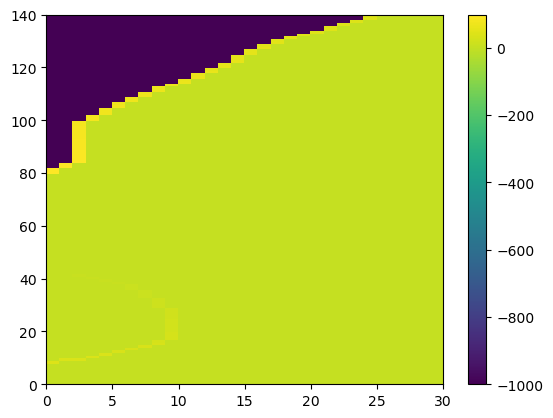

In [151]:
plt.pcolor(contour_masked_above)
plt.colorbar()

In [152]:
import numpy.ma as ma

mask_shelf2 = ma.masked_where(contour_masked_above == -1000, np.ones(h.shape))

# Direction of cross-contour transport

mask_x_transport = np.zeros_like(contour_mask_numbered)
mask_y_transport = np.zeros_like(contour_mask_numbered)

mask_y_transport_numbered = np.zeros_like(contour_mask_numbered)
mask_x_transport_numbered = np.zeros_like(contour_mask_numbered)

# make halos: add 2 extra columns with the value of the last/first columns of the original
shape = contour_masked_above.shape
contour_masked_above_halo = np.zeros((shape[0], shape[1]+2))
contour_masked_above_halo[:, 0] = contour_masked_above[:, -1]
contour_masked_above_halo[:, 1:-1] = contour_masked_above
contour_masked_above_halo[:, -1] = contour_masked_above[:, 0]

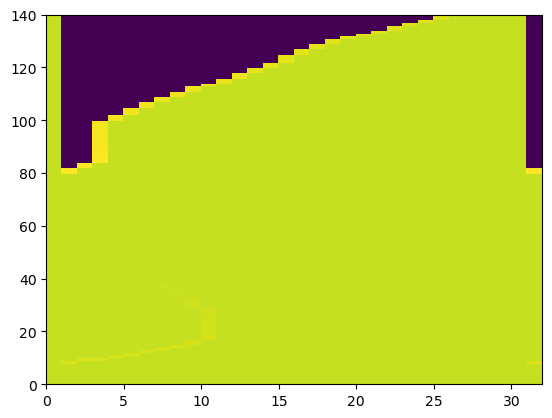

In [153]:
plt.pcolor(contour_masked_above_halo)

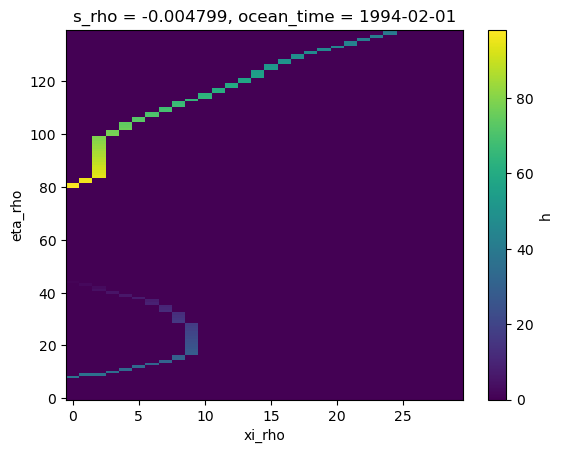

In [154]:
contour_mask_numbered.plot()

In [155]:
int(np.max(contour_mask_numbered))

98

In [156]:

new_number_count = 1
for mask_loc in range(1, int(np.max(contour_mask_numbered))+1):
    print(mask_loc)
    #if mask_loc%100 == 0:
    #    print('mask for x/y transport at point '+str(mask_loc))
    index_i = np.where(contour_mask_numbered==mask_loc)[1]
    index_j = np.where(contour_mask_numbered==mask_loc)[0]


    # if point above is towards Antarctica and point below is away from Antarctica:
    # take transport grid point to north of t grid:
    if (contour_masked_above[index_j, index_i]==0) and (contour_masked_above[index_j-1, index_i]!=0):
        mask_y_transport[index_j, index_i] = -1
        # important to do
        mask_y_transport_numbered[index_j, index_i] = new_number_count
        new_number_count += 1
    # if point below is towards Antarctica and point above is away from Antarctica:
    # take transport grid point to south of t grid:
    elif (contour_masked_above[index_j-1, index_i]==0) and (contour_masked_above[index_j+1, index_i]!=0):
        mask_y_transport[index_j-1, index_i] = 1
        mask_y_transport_numbered[index_j-1, index_i] = new_number_count
        new_number_count += 1
    # if point to right is towards Antarctica and point to left is away from Antarctica:
    # zonal indices increased by 1 due to halos
    # take transport grid point on right of t grid:
    if (contour_masked_above_halo[index_j, index_i+2]==0) and (contour_masked_above_halo[index_j, index_i]!=0):
        mask_x_transport[index_j, index_i] = -1
        mask_x_transport_numbered[index_j, index_i] = new_number_count
        new_number_count += 1
    # if point to left is towards Antarctica and point to right is away from Antarctica:
    # take transport grid point on left of t grid:
    elif (contour_masked_above_halo[index_j, index_i]==0) and (contour_masked_above_halo[index_j, index_i+2]!=0):
        mask_x_transport[index_j, index_i-1] = 1
        mask_x_transport_numbered[index_j, index_i-1] = new_number_count
        new_number_count += 1


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98


In [157]:
print(pm.shape, pn.shape)

(140, 30) (140, 30)


In [158]:
import pyresample

rho_def = pyresample.geometry.SwathDefinition(lons=lon_rho,lats=lat_rho)
u_def = pyresample.geometry.SwathDefinition(lons=lon_u,lats=lat_u)
v_def = pyresample.geometry.SwathDefinition(lons=lon_v,lats=lat_v)

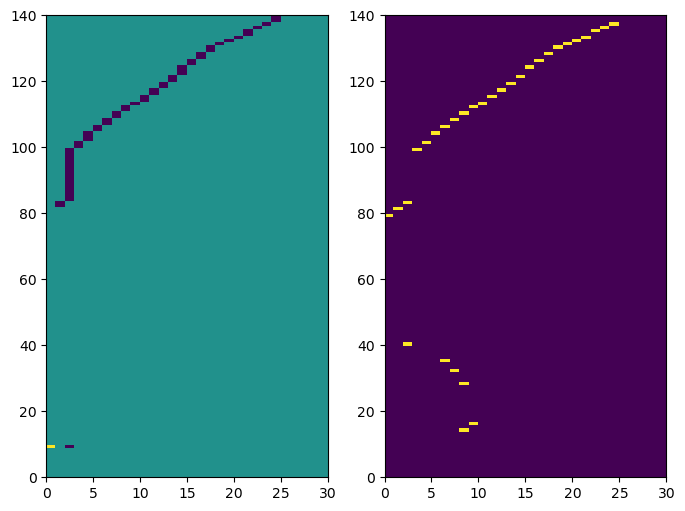

In [159]:
fig, ax = plt.subplots(ncols=2, figsize=(8,6))
ax[0].pcolor(mask_x_transport)
ax[1].pcolor(mask_y_transport)

In [160]:

wf = lambda r: 1/r

mask_x_transport_Ugrd = pyresample.kd_tree.resample_custom(rho_def,mask_x_transport,u_def,\
                                            radius_of_influence=100000,neighbours=1,weight_funcs=wf)
mask_y_transport_Vgrd = pyresample.kd_tree.resample_custom(rho_def,mask_y_transport,v_def,\
                                            radius_of_influence=100000,neighbours=1,weight_funcs=wf)
mask_x_transport_numbered_Ugrd = pyresample.kd_tree.resample_custom(rho_def,mask_x_transport_numbered,u_def,\
                                            radius_of_influence=100000,neighbours=1,weight_funcs=wf)
mask_y_transport_numbered_Vgrd = pyresample.kd_tree.resample_custom(rho_def,mask_y_transport_numbered,v_def,\
                                            radius_of_influence=100000,neighbours=1,weight_funcs=wf)


In [161]:
# Convert contour masks to data arrays, so we can multiply them later.
# We need to ensure the lat lon coordinates correspond to the actual data location:
#       The y masks are used for ty_trans, so like vhrho this should have dimensions (yu_ocean, xt_ocean).
#       The x masks are used for tx_trans, so like uhrho this should have dimensions (yt_ocean, xu_ocean).
#       However the actual name will always be simply y_ocean/x_ocean irrespective of the variable
#       to make concatenation of transports in both direction and sorting possible.
coordinates=dict(one=lon_rho, two=lat_rho)
coordinatesU=dict(one=lon_u, two=lat_u)
coordinatesV=dict(one=lon_v, two=lat_v)


mask_x_transport_Ugrd = xr.DataArray(mask_x_transport_Ugrd, coords = coordinatesU, dims = ['eta_u', 'xi_u'])
mask_y_transport_Vgrd = xr.DataArray(mask_y_transport_Vgrd, coords = coordinatesV, dims = ['eta_v', 'xi_v'])
mask_x_transport_numbered_Ugrd = xr.DataArray(mask_x_transport_numbered_Ugrd, coords = coordinatesU, dims = ['eta_u', 'xi_u'])
mask_y_transport_numbered_Vgrd = xr.DataArray(mask_y_transport_numbered_Vgrd, coords = coordinatesV, dims = ['eta_v', 'xi_v'])

# rename dimensions as simply eta/xi
mask_x_transport_Ugrd = mask_x_transport_Ugrd.rename({'eta_u': 'eta','xi_u': 'xi'})
mask_y_transport_Vgrd = mask_y_transport_Vgrd.rename({'eta_v': 'eta','xi_v': 'xi'})
mask_x_transport_numbered_Ugrd = mask_x_transport_numbered_Ugrd.rename({'eta_u': 'eta','xi_u': 'xi'})
mask_y_transport_numbered_Vgrd = mask_y_transport_numbered_Vgrd.rename({'eta_v': 'eta','xi_v': 'xi'})

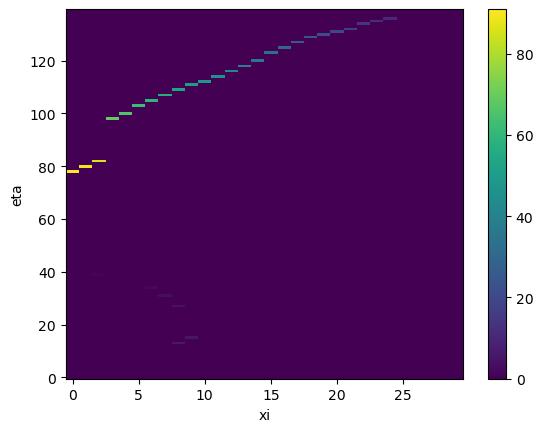

In [162]:
mask_y_transport_numbered_Vgrd.plot()

In [163]:
# Create the contour order data-array. Note that in this procedure the x-grid counts have x-grid
#   dimensions and the y-grid counts have y-grid dimensions, but these are implicit, the dimension
#   *names* are kept general across the counts, the generic y_ocean, x_ocean, so that concatening works
#   but we dont double up with numerous counts for one lat/lon point.

# stack contour data into 1d:
mask_x_numbered_1d = mask_x_transport_numbered_Ugrd.stack(contour_index = ['eta', 'xi'])
mask_x_numbered_1d = mask_x_numbered_1d.where(mask_x_numbered_1d > 0, drop = True)

mask_y_numbered_1d = mask_y_transport_numbered_Vgrd.stack(contour_index = ['eta', 'xi'])
mask_y_numbered_1d = mask_y_numbered_1d.where(mask_y_numbered_1d > 0, drop = True)

contour_ordering = xr.concat((mask_x_numbered_1d, mask_y_numbered_1d), dim = 'contour_index', data_vars="all")
contour_ordering = contour_ordering.sortby(contour_ordering)
contour_index_array = np.arange(1, len(contour_ordering)+1)

In [164]:
contour_index_array

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90])

In [165]:

def extract_transp_across_contour(temp, var_x, var_y):   # var:4D [time,eta_rho,xi_rho]

    zlen = len(temp[:,0,0])
    tlen = 1
    print(tlen,zlen)
    transp_across_contour = np.empty((tlen,zlen,len(contour_ordering)))

    for tt in range(0,tlen): # loop through time
        for zz in range(0,zlen): # loop through z-levels

            print('Debugging high memory usage: ')
            print(tt, zz)

            var_x_tmp = var_x.isel(s_rho=zz) * mask_x_transport_Ugrd.isel(eta=eta_slice, xi=xi_slice)
            var_y_tmp = var_y.isel(s_rho=zz) * mask_y_transport_Vgrd.isel(eta=eta_slice, xi=xi_slice)
            
            print('var_x_tmp/var_y_tmp shapes after mask multip.:')
            print(var_x_tmp.shape, var_y_tmp.shape)
            
            # stack transports into 1d and drop any points not on contour:
            x_var_1d_tmp = var_x_tmp.stack(contour_index = ['eta', 'xi'])
            x_var_1d_tmp = x_var_1d_tmp.where(mask_x_numbered_1d>0, drop = True)
            y_var_1d_tmp = var_y_tmp.stack(contour_index = ['eta', 'xi'])
            y_var_1d_tmp = y_var_1d_tmp.where(mask_y_numbered_1d>0, drop = True)

            print('x_var_1d_tmp/y_var_1d_tmp shapes after stack:')
            print(x_var_1d_tmp.shape, y_var_1d_tmp.shape)

            # combine all points on contour:
            transp_across_contour_tmp = xr.concat((x_var_1d_tmp, y_var_1d_tmp), dim = 'contour_index')
            transp_across_contour_tmp = transp_across_contour_tmp.reset_index('contour_index') # added by fabio, otherwise it crashes due to duplicated indices
            transp_across_contour_tmp = transp_across_contour_tmp.sortby(contour_ordering)
            transp_across_contour_tmp.coords['contour_index'] = contour_index_array
            transp_across_contour_tmp = transp_across_contour_tmp.load()

            print(tt, zz, transp_across_contour_tmp.shape)
            transp_across_contour[tt,zz,:] = transp_across_contour_tmp
            del transp_across_contour_tmp

    return transp_across_contour

In [166]:
temp = dg.temp.isel(ocean_time=0)
v = dg.v_northward.isel(ocean_time=0)
u = dg.u_eastward.isel(ocean_time=0)


In [167]:
# determine constants:
rho0 = 1025 # kg. m-3
Cp = 3989.245 # J.kg-1.degC-1


# Bad calculation of heat transport, due to the use of rho points!!!! FS
v_heat_trans = (temp * v * Cp * rho0).isel(eta_rho=eta_slice, xi_rho=xi_slice)
u_heat_trans = (temp * u * Cp * rho0).isel(eta_rho=eta_slice, xi_rho=xi_slice)





In [ ]:
extract_transp_across_contour(temp, u_heat_trans, v_heat_trans)

In [170]:

zlen = len(temp[:,0,0])
tlen = 1
print(tlen,zlen)
transp_across_contour = np.empty((tlen,zlen,len(contour_ordering)))

for tt in range(0,tlen): # loop through time
    for zz in range(0,zlen): # loop through z-levels

        print('Debugging high memory usage: ')
        print(tt, zz)

        var_x_tmp = u_heat_trans.isel(s_rho=zz) * mask_x_transport_Ugrd.isel(eta=eta_slice, xi=xi_slice)
        var_y_tmp = v_heat_trans.isel(s_rho=zz) * mask_y_transport_Vgrd.isel(eta=eta_slice, xi=xi_slice)
        
        print('var_x_tmp/var_y_tmp shapes after mask multip.:')
        print(var_x_tmp.shape, var_y_tmp.shape)
        
        # stack transports into 1d and drop any points not on contour:
        x_var_1d_tmp = var_x_tmp.stack(contour_index = ['eta', 'xi'])
        x_var_1d_tmp = x_var_1d_tmp.where(mask_x_numbered_1d>0, drop = True)
        y_var_1d_tmp = var_y_tmp.stack(contour_index = ['eta', 'xi'])
        y_var_1d_tmp = y_var_1d_tmp.where(mask_y_numbered_1d>0, drop = True)

        print('x_var_1d_tmp/y_var_1d_tmp shapes after stack:')
        print(x_var_1d_tmp.shape, y_var_1d_tmp.shape)

        # combine all points on contour:
        transp_across_contour_tmp = xr.concat((x_var_1d_tmp, y_var_1d_tmp), dim = 'contour_index')
        transp_across_contour_tmp = transp_across_contour_tmp.reset_index('contour_index') # added by fabio, otherwise it crashes due to duplicated indices
        transp_across_contour_tmp = transp_across_contour_tmp.sortby(contour_ordering)
        transp_across_contour_tmp.coords['contour_index'] = contour_index_array
        transp_across_contour_tmp = transp_across_contour_tmp.load()

        print(tt, zz, transp_across_contour_tmp.shape)
        transp_across_contour[tt,zz,:] = transp_across_contour_tmp
        del transp_across_contour_tmp

1 30
Debugging high memory usage: 
0 0
var_x_tmp/var_y_tmp shapes after mask multip.:
(140, 30, 130, 0) (140, 30, 130, 0)
x_var_1d_tmp/y_var_1d_tmp shapes after stack:
(140, 30, 0) (140, 30, 0)


ValueError: cannot reindex or align along dimension 'contour_index' because of conflicting dimension sizes: {0, 90} (note: an index is found along that dimension with size=90)

In [172]:
transp_across_contour_tmp

<xarray.DataArray (eta_rho: 140, xi_rho: 30, contour_index: 0)>
array([], shape=(140, 30, 0), dtype=float64)
Coordinates:
    eta         (contour_index) int64 
    xi          (contour_index) int64 
    s_rho       float64 -0.9715
    lon_rho     (eta_rho, xi_rho) float64 149.6 149.6 149.7 ... 152.8 152.8
    lat_rho     (eta_rho, xi_rho) float64 -38.74 -38.74 -38.75 ... -33.07 -33.07
    ocean_time  datetime64[ns] 1994-02-01
    one         (contour_index) float64 
    two         (contour_index) float64 
Dimensions without coordinates: eta_rho, xi_rho, contour_index